In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'

In [3]:

figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_drift_model'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)


/mnt/home/szheng/ceph/place_variability/fig/paper/figure_drift_model made!


'/mnt/home/szheng/ceph/place_variability/data/paper'

In [4]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

Points I would like to make: 
1) RD is indeed drift and not trial variability

2) Population drift is driven by change in individual FR, not location

3) Drift is coordinated across neurons


In [90]:
n_neuron = 200
n_pos = 100
n_trial = 30

def gen_data(**kwargs):
    '''
    each neuron one field, field uniform tiling
    each field is a gaussian with a width (first normalized by its mean), multiplied by a scaler at each trial (representing its mean within that trial)
    width: gamma distribution
    mean_fr: gamma distribution
    trial to trial variability of fr: first sample cv from a log normal distribution, then get the std_fr
    with mean_fr and std_fr, get the scaler for each neuron+trial
    '''
    n_neuron = kwargs.get('n_neuron',200)
    n_pos = kwargs.get('n_pos',100)
    pos_l = np.arange(n_pos)
    n_trial = kwargs.get('n_trial',30)
    width_gamma_alpha = kwargs.get('width_gamma_alpha',0.84)
    width_gamma_loc = kwargs.get('width_gamma_loc',4)
    width_gamma_scale = kwargs.get('width_gamma_scale',6.6)
    width_max = kwargs.get('width_max',30)
    
    mean_fr_gamma_alpha = kwargs.get('mean_fr_gamma_alpha',1.67)
    mean_fr_gamma_loc = kwargs.get('mean_fr_gamma_loc',0.5)
    mean_fr_gamma_scale = kwargs.get('mean_fr_gamma_scale',2.4)
    
    log_cv_mean = kwargs.get('log_cv_mean',0.5)
    log_cv_std = kwargs.get('log_cv_std',0.5)
        
    peak_pos = np.linspace(0,n_pos-1,n_neuron)
    width = scipy.stats.gamma.rvs(width_gamma_alpha,loc=width_gamma_loc,scale=width_gamma_scale,size=n_neuron)
    width[width>width_max] = width_max
    
    mean_fr = scipy.stats.gamma.rvs(mean_fr_gamma_alpha,loc=mean_fr_gamma_loc,scale=mean_fr_gamma_scale,size=n_neuron)
    
    
    log_cv = np.random.normal(size=n_neuron)* log_cv_std + log_cv_mean
    cv = np.exp(log_cv)
    std = mean_fr / cv
    
    scaling_per_neuron_trial = np.random.normal(size=(n_neuron,n_trial)) * std[:,None] + mean_fr[:,None]
    
    baseline_l=[]
    for pos in pos_l:
        baseline = scipy.stats.norm(loc=peak_pos,scale=width).pdf(pos) # n_neuron x n_pos
        baseline_l.append(baseline)
    baseline_l = np.stack(baseline_l,axis=1)
    baseline_l = baseline_l/baseline_l.mean(axis=1,keepdims=True)
#     pdb.set_trace()   
    frmap = np.einsum('np,nt->npt',baseline_l,scaling_per_neuron_trial)
    
    
#     mean_ratemap = 
    
    return frmap,cv,log_cv


In [91]:
frmap,cv,log_cv = gen_data()

In [92]:
np.std(np.log(cv))

0.5131715965528433

(array([10., 11., 14., 34., 43., 37., 30.,  9.,  8.,  4.]),
 array([-0.68363444, -0.4284855 , -0.17333657,  0.08181236,  0.33696129,
         0.59211022,  0.84725915,  1.10240808,  1.35755701,  1.61270594,
         1.86785487]),
 <BarContainer object of 10 artists>)

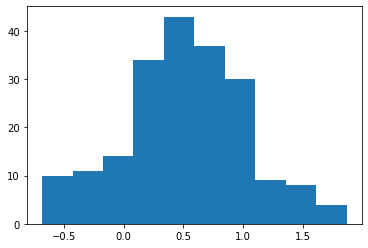

In [93]:
plt.hist(log_cv)

(array([37., 65., 46., 30.,  6.,  7.,  4.,  2.,  2.,  1.]),
 array([0.50477907, 1.10174047, 1.69870187, 2.29566328, 2.89262468,
        3.48958608, 4.08654749, 4.68350889, 5.28047029, 5.8774317 ,
        6.4743931 ]),
 <BarContainer object of 10 artists>)

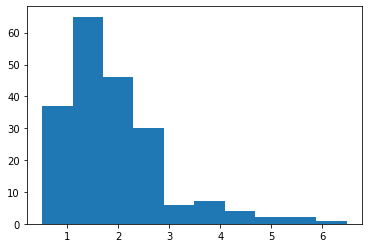

In [94]:
plt.hist(cv)

(array([47., 52., 51., 24., 12.,  8.,  3.,  2.,  0.,  1.]),
 array([ 0.22017559,  2.13808364,  4.05599168,  5.97389972,  7.89180776,
         9.80971581, 11.72762385, 13.64553189, 15.56343993, 17.48134797,
        19.39925602]),
 <BarContainer object of 10 artists>)

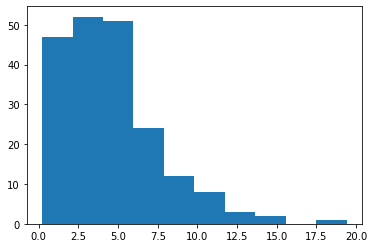

In [95]:
plt.hist(frmap.mean(axis=(1,2)))

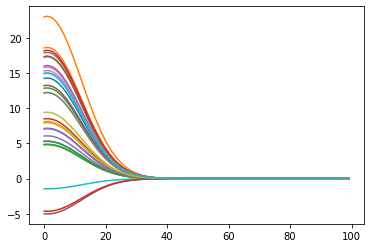

In [99]:
plt.plot(frmap[2,:,:])

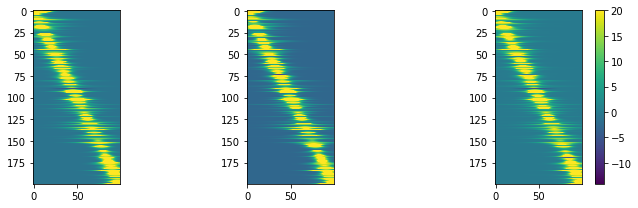

In [77]:
fig,axs=plt.subplots(1,3,figsize=(10,3))
vmax =20
for ii,tr in enumerate([0,10,20]):
    im=axs[ii].imshow(frmap[:,:,tr],vmax=vmax)
plt.colorbar(im)
plt.tight_layout()

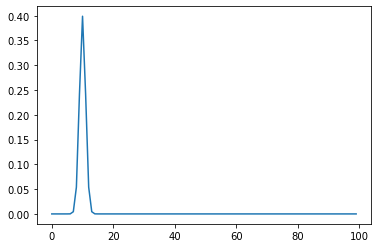

In [18]:
plt.plot(scipy.stats.norm(10).pdf(np.arange(100)))

In [10]:

peak_pos = gen_data()

(array([85., 48., 22., 14., 15.,  2.,  0.,  5.,  0.,  9.]),
 array([ 4.00926247,  6.60833622,  9.20740998, 11.80648373, 14.40555748,
        17.00463123, 19.60370499, 22.20277874, 24.80185249, 27.40092625,
        30.        ]),
 <BarContainer object of 10 artists>)

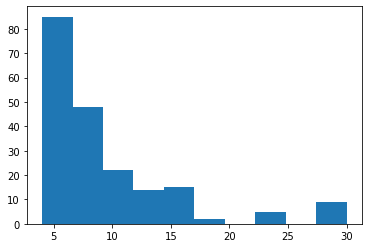

In [13]:
plt.hist(peak_pos)